In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MultipleLocator
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import joblib


In [2]:
df = pd.read_csv("/kaggle/input/house-price-lr-univariable/training.csv")
df.head()

,price,sq_meter
0,149000.0,157.93
1,292600.0,141.21
2,968000.0,335.38
3,432500.0,208.10
4,382500.0,96.62


In [3]:
df.info

<bound method DataFrame.info of          price  sq_meter
0     149000.0    157.93
1     292600.0    141.21
2     968000.0    335.38
3     432500.0    208.10
4     382500.0     96.62
...        ...       ...
2960  263000.0    146.79
2961  216500.0    129.13
2962  440000.0    223.89
2963  642000.0    236.90
2964  648000.0    305.65

[2965 rows x 2 columns]>

In [4]:
# df.drop([ 'price', 'sq_meter'], axis=1, inplace=True)

In [5]:
df['sq_meter'] = df['sq_meter'].round(0).astype(int)
df['price'] = df['price'].round(0).astype(int)
df.head()
col_names = df.columns.tolist()
print(col_names)

['price', 'sq_meter']


In [6]:
nan_values = df.isna()

any_missing_values = nan_values.any().any()

any_missing_values_in_column = nan_values.any()

missing_value_count = df.isnull().sum()


for column, has_missing in any_missing_values_in_column.items():
    if has_missing:
        count = missing_value_count[column]
        print(f"-----> Column '{column}' has {count} missing values.")
        
print("\nMissing Values in the Entire DataFrame?")
print(any_missing_values)

print("\nMissing Values in Each Column?")
print(any_missing_values_in_column)

print("\nMissing Value Counts in Each Column:")
print(missing_value_count)


Missing Values in the Entire DataFrame?
False

Missing Values in Each Column?
price       False
sq_meter    False
dtype: bool

Missing Value Counts in Each Column:
price       0
sq_meter    0
dtype: int64


In [7]:
def apply_filter_to_column(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    threshold_multiplier = 3.0
    
    lower_bound = Q1 - threshold_multiplier * IQR
    upper_bound = Q3 + threshold_multiplier * IQR

    filtered_column = df[column].apply(lambda x: x if (x >= lower_bound) and (x <= upper_bound) else None)
    return filtered_column

data_to_filter = ['price', 'sq_meter']


df_copy = df.copy()

for column in data_to_filter:
    filtered_column = apply_filter_to_column(column)
    df_copy[f'{column}_filtered'] = filtered_column


df_copy = df_copy.dropna(how='all', subset=[f'{column}_filtered' for column in data_to_filter])

filtered_columns = df_copy.columns.tolist()

print(filtered_columns)

['price', 'sq_meter', 'price_filtered', 'sq_meter_filtered']


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

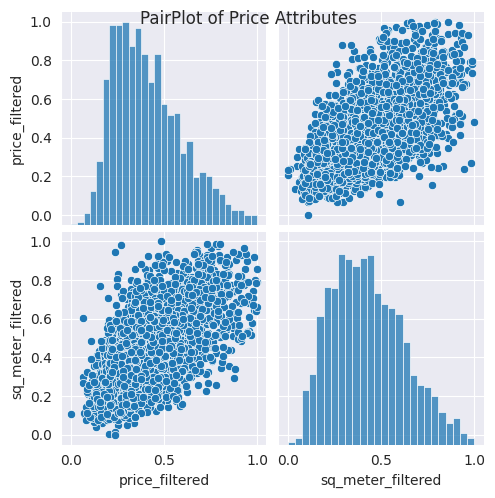

In [8]:
data_to_plot = ['price_filtered', 'sq_meter_filtered']
if df_copy is not None and not df_copy.empty:
    scaler = MinMaxScaler()
    df_copy = scaler.fit_transform(df_copy[data_to_plot])
    df_copy = pd.DataFrame(df_copy, columns=data_to_plot)
    plt.figure(figsize=(6, 6))
    sns.pairplot(df_copy)
    plt.suptitle('PairPlot of Price Attributes')
    plt.show()
else:
    print("Filtered data is empty or None. Check your ebalo")

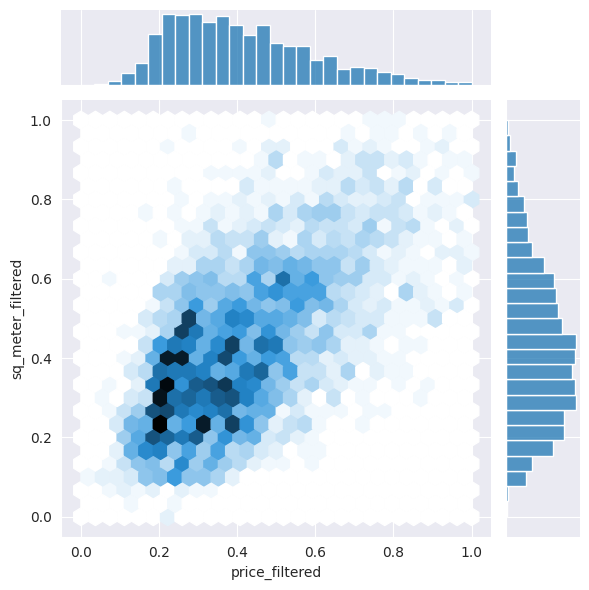

In [9]:
sns.jointplot(data=df_copy, x='price_filtered', y='sq_meter_filtered', kind = "hex", dropna=True)

In [10]:
df_x = df_copy['sq_meter_filtered'].to_numpy()
df_y = df_copy['price_filtered'].to_numpy()

indexes_to_remove = np.where(df_y == 0)[0]
df_y = np.delete(df_y, indexes_to_remove)
df_x = np.delete(df_x, indexes_to_remove)

df_copy.dropna(subset=['price_filtered', 'sq_meter_filtered'], inplace=True)
if df_copy[['price_filtered', 'sq_meter_filtered']].isna().any().any():
    print("There are still NaN values in the data.")
else:
    print("No NaN values found, proceed with model training.")

No NaN values found, proceed with model training.


In [11]:
df_x = df_x.reshape(-1, 1)
dx_y = df_y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (2371, 1)
y_train shape: (2371,)


In [12]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [13]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.020402817093343507
R-squared: 0.38952819068612643


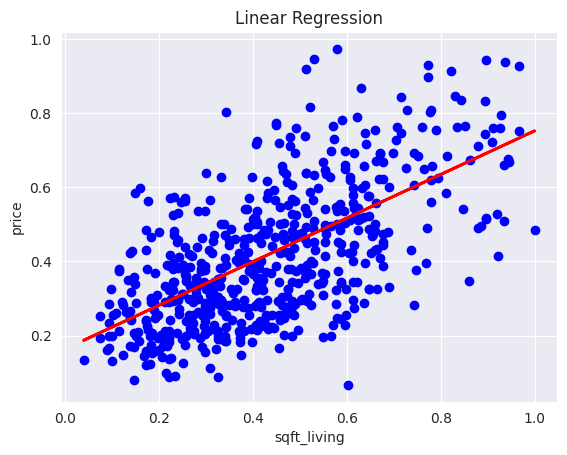

In [14]:
plt.scatter(x_test, y_test, color='blue')
plt.plot(x_test, y_pred, color='red', linewidth=2)
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.title('Linear Regression')
plt.show()

In [15]:
joblib.dump(model, 'linear_regression.pkl')

['linear_regression.pkl']

In [16]:
model = joblib.load('linear_regression.pkl')
data_test = pd.DataFrame({'sqft_living': [0.6, 0.2, 1]})
predictions = model.predict(data_test)
print(predictions)

[0.51692018 0.28139049 0.75244987]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
